# NYC-Taxi-FHV-Project
![cover.png](../Data/cover.png)

In [2]:
import pandas as pd #DataFrame
import numpy as np #For array
import os #for os commands
from math import sin, cos, sqrt, atan2, radians, log #For calculation
import time           #to get the system time
import datetime       #for datetime operations
import holidays       #For extract date time of holidays
import calendar       #For calendar for datetime operations

pd.set_option('display.max_columns', 500)
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="E:/GitHub/NYC-Taxi-FHV-Project/Data/My First Project-b3735f3b3a9d.json"
#os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="./My Project 14295-223aab171173.json"
from google.cloud import bigquery
client = bigquery.Client()

#For geospatial data
import geopandas as gpd   #For geospatial data
import shapely
import pysal as ps
from fiona.crs import from_epsg
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
import geohash_hilbert as ghh # For geohash code
import shapefile

#For machine learning models
import sklearn
from sklearn.linear_model import LinearRegression, Ridge,BayesianRidge #For lasso and ridge
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

#For visualization purpose
from scipy.misc import imread, imresize, imsave 
from pandas.plotting import scatter_matrix
import scipy         #for other dependancies
import seaborn as sns #for making plots
from scipy.misc import imread, imresize, imsave  
from bokeh.palettes import Spectral4
from bokeh.plotting import figure, output_notebook, show
from IPython.display import HTML
from matplotlib.pyplot import *
from matplotlib import animation
from scipy.misc import imread, imresize, imsave

import matplotlib.pyplot as plt
%matplotlib inline

sns.set(style="whitegrid")

## 1. Data Processing

### 1.1 Query Taxi Data from BigQuery

In [3]:
start = time.time()
query = (
"""
SELECT x.travel_time,
    pickup_datetime,
    dropoff_datetime,
    x.date,
    x.month,
    x.day,
    FORMAT_DATE('%A', x.date) as wkday,
    pick_hour,
    pickup_location_id,
    dropoff_location_id,
    'Taxi' as type,
    wdsp as AWND,
    prcp as PRCP,
    snow_ice_pellets as SNOW,
    sndp as SNWD,
    max as TMAX,
    min as TMIN
FROM
(
      SELECT *,ROW_NUMBER() OVER(partition by date, pick_hour) as row_number
      FROM
      (
            SELECT pickup_datetime, dropoff_datetime, pickup_location_id, dropoff_location_id,
            EXTRACT (HOUR FROM pickup_datetime) as pick_hour,
            EXTRACT (DAY FROM pickup_datetime) as day,
            EXTRACT (MONTH FROM pickup_datetime) as month,
            EXTRACT (DATE FROM pickup_datetime) as date,
            TIMESTAMP_DIFF(TIMESTAMP(dropoff_datetime), TIMESTAMP(pickup_datetime), SECOND) as travel_time,
            passenger_count
            FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2018`
      ) x
      where x.travel_time > 0
) x
JOIN
(
 select cast(mo as int64) as month,cast(da as int64) as day,temp,visib,mxpsd,wdsp,gust,max,min,prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder
 from `bigquery-public-data.noaa_gsod.gsod2018` where stn='725053'
) y on x.month = y.month and x.day = y.day
where x.row_number <= 20
"""
)
Taxi = pd.io.gbq.read_gbq(query,dialect='standard')
       
end = time.time()
print("Time taken by above cell is {} mins.".format(round((end-start)/60,2)))

Time taken by above cell is 0.63 mins.


### 1.2 Combine Taxi and FHV Data

#### Loading and combining Uber, Lyft,Via data from local to Taxi data

In [4]:
FHV = pd.read_csv('../Data/1-12_weather_mini.csv')
data = pd.concat([Taxi, FHV], axis=0, sort=False)

data.wkday = pd.Categorical(data.wkday, categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                            ordered=True)

data.head()

,travel_time,pickup_datetime,dropoff_datetime,date,month,day,wkday,pick_hour,pickup_location_id,dropoff_location_id,type,AWND,PRCP,SNOW,SNWD,TMAX,TMIN
0,429,2018-03-07 09:47:37,2018-03-07 09:54:46,2018-03-07 00:00:00,3,7,Wednesday,9,163,50,Taxi,8.7,0.11,1,999.9,46.9,32.0
1,426,2018-03-07 09:12:01,2018-03-07 09:19:07,2018-03-07 00:00:00,3,7,Wednesday,9,226,145,Taxi,8.7,0.11,1,999.9,46.9,32.0
2,674,2018-03-07 09:58:27,2018-03-07 10:09:41,2018-03-07 00:00:00,3,7,Wednesday,9,186,48,Taxi,8.7,0.11,1,999.9,46.9,32.0
3,431,2018-03-07 09:31:58,2018-03-07 09:39:09,2018-03-07 00:00:00,3,7,Wednesday,9,164,113,Taxi,8.7,0.11,1,999.9,46.9,32.0
4,409,2018-03-07 09:26:46,2018-03-07 09:33:35,2018-03-07 00:00:00,3,7,Wednesday,9,48,186,Taxi,8.7,0.11,1,999.9,46.9,32.0


In [6]:
sf = shapefile.Reader("../Data/taxi_zones/geo_export_5c667c84-e344-4ff1-896e-9b2483684b97.shp")
fields_name = [field[0] for field in sf.fields[1:]]
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
attributes = sf.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]

df_loc = pd.DataFrame(shp_attr).join(get_lat_lon(sf).set_index('location_i'), on='location_i')
df_loc.head()

,borough,location_i,objectid,shape_area,shape_leng,zone,longitude,latitude
0,EWR,1.0,1.0,0.000782,0.116357,Newark Airport,-74.171533,40.689483
1,Queens,2.0,2.0,0.004866,0.433470,Jamaica Bay,-73.822478,40.610824
2,Bronx,3.0,3.0,0.000314,0.084341,Allerton/Pelham Gardens,-73.844953,40.865747
3,Manhattan,4.0,4.0,0.000112,0.043567,Alphabet City,-73.977725,40.724137
4,Staten Island,5.0,5.0,0.000498,0.092146,Arden Heights,-74.187558,40.550664


### 1.3 Check Missing Value

#### Generate **heatmap** to check missing value pattern, and also check missing value by each feature 

                     counts
AWND                  38825
dropoff_location_id      76
pickup_location_id        1
TMAX                      0
SNWD                      0
SNOW                      0
PRCP                      0
type                      0
travel_time               0
pickup_datetime           0
pick_hour                 0
wkday                     0
day                       0
month                     0
date                      0
dropoff_datetime          0
TMIN                      0


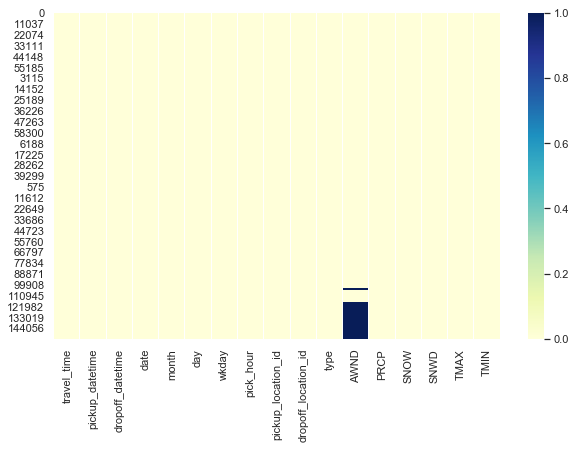

In [9]:
print(pd.DataFrame(data.isna().sum(axis=0),columns=['counts']).sort_values(by='counts',ascending=False))

plt.figure(figsize=(10,6))
sns.heatmap(data.isna(),cmap="YlGnBu")
plt.show()

#### Remove missing value for pickup and droppoff location, and replace `AWND` missing by median 

In [10]:
data.AWND.replace(999.9, np.NaN).fillna(data.AWND.median(), inplace=True) 

data.dropna(axis=0, inplace=True)

### 1.4 Create Taxi Zones

In [11]:
def get_lat_lon(sf):
    content = []
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['location_i']]
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        
        content.append((loc_id, x, y))
    return pd.DataFrame(content, columns=["location_i", "longitude", "latitude"])

sf = shapefile.Reader("../Data/taxi_zones/geo_export_5c667c84-e344-4ff1-896e-9b2483684b97.shp")
fields_name = [field[0] for field in sf.fields[1:]]
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
attributes = sf.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]

df_loc = pd.DataFrame(shp_attr).join(get_lat_lon(sf).set_index('location_i'), on='location_i')
df_loc.head()

,borough,location_i,objectid,shape_area,shape_leng,zone,longitude,latitude
0,EWR,1.0,1.0,0.000782,0.116357,Newark Airport,-74.171533,40.689483
1,Queens,2.0,2.0,0.004866,0.433470,Jamaica Bay,-73.822478,40.610824
2,Bronx,3.0,3.0,0.000314,0.084341,Allerton/Pelham Gardens,-73.844953,40.865747
3,Manhattan,4.0,4.0,0.000112,0.043567,Alphabet City,-73.977725,40.724137
4,Staten Island,5.0,5.0,0.000498,0.092146,Arden Heights,-74.187558,40.550664


In [12]:
data.pickup_location_id = data.pickup_location_id.astype(int)
data.dropoff_location_id = data.dropoff_location_id.astype(int)

data = pd.merge(data, df_loc[['location_i', 'borough', 'zone', 'longitude', 'latitude']],
                  left_on = 'pickup_location_id', right_on = 'location_i', how='inner').drop(columns='location_i')

data = pd.merge(data, df_loc[['location_i', 'borough', 'zone', 'longitude', 'latitude']],
                  left_on = 'dropoff_location_id', right_on = 'location_i', how='inner').drop(columns='location_i')

data.columns = ['travel_time', 'pickup_datetime', 'dropoff_datetime', 'date', 'month','day', 'wkday', 'pick_hour', 'pickup_location_id',
                  'dropoff_location_id', 'type', 'AWND', 'PRCP', 'SNOW', 'SNWD', 'TMAX','TMIN',
                  'pickup_borough', 'pickup_zone', 'pickup_longitude','pickup_latitude',
                  'dropoff_borough', 'dropoff_zone', 'dropoff_longitude', 'dropoff_latitude']
data.head()

,travel_time,pickup_datetime,dropoff_datetime,date,month,day,wkday,pick_hour,pickup_location_id,dropoff_location_id,type,AWND,PRCP,SNOW,SNWD,TMAX,TMIN,pickup_borough,pickup_zone,pickup_longitude,pickup_latitude,dropoff_borough,dropoff_zone,dropoff_longitude,dropoff_latitude
0,429,2018-03-07 09:47:37,2018-03-07 09:54:46,2018-03-07 00:00:00,3,7,Wednesday,9,163,50,Taxi,8.7,0.11,1,999.9,46.9,32.0,Manhattan,Midtown North,-73.977041,40.764387,Manhattan,Clinton West,-73.99591,40.766568
1,209,2018-04-16 13:41:58,2018-04-16 13:45:27,2018-04-16 00:00:00,4,16,Monday,13,163,50,Taxi,11.5,1.68,0,999.9,59.0,37.4,Manhattan,Midtown North,-73.977041,40.764387,Manhattan,Clinton West,-73.99591,40.766568
2,191,2018-09-25 01:52:58,2018-09-25 01:56:09,2018-09-25 00:00:00,9,25,Tuesday,1,163,50,Taxi,3.6,0.27,0,999.9,73.4,59.0,Manhattan,Midtown North,-73.977041,40.764387,Manhattan,Clinton West,-73.99591,40.766568
3,556,2018-08-12 20:47:22,2018-08-12 20:56:38,2018-08-12 00:00:00,8,12,Sunday,20,163,50,Taxi,1.6,1.94,0,999.9,84.0,70.0,Manhattan,Midtown North,-73.977041,40.764387,Manhattan,Clinton West,-73.99591,40.766568
4,1541,2018-09-11 10:46:34,2018-09-11 11:12:15,2018-09-11 00:00:00,9,11,Tuesday,10,163,50,Taxi,2.3,0.51,0,999.9,73.9,54.0,Manhattan,Midtown North,-73.977041,40.764387,Manhattan,Clinton West,-73.99591,40.766568


### 1.5 Check Outlier

### 1.5.1 Abnormal Trip Time

#### Some passengers get on taxi then get off immediately, so the time is near zero. Many rows do have zero for pickup or drop off location or almost same location for pick up and drop off.  Therefore, we are only considered the travel time is at least 120 second and no longer than 3 hours.

In [13]:
data.loc[(data.travel_time <= 60), ['travel_time','pickup_zone', 'dropoff_zone']].head(10)

,travel_time,pickup_zone,dropoff_zone
451,53,Clinton East,Clinton West
932,21,Upper West Side South,Clinton West
2513,41,Clinton West,Clinton West
2521,39,Clinton West,Clinton West
2528,25,Clinton West,Clinton West
2532,52,Clinton West,Clinton West
2534,4,Clinton West,Clinton West
2537,3,Clinton West,Clinton West
5341,35,UN/Turtle Bay South,Kips Bay
5922,46,Kips Bay,Kips Bay


In [14]:
data.loc[(data.travel_time >= 10800), ['travel_time','pickup_zone', 'dropoff_zone']].head(10)

,travel_time,pickup_zone,dropoff_zone
298,83604,Midtown South,Clinton West
1208,84181,Midtown Center,Clinton West
1951,85844,Lincoln Square East,Clinton West
2332,83882,Lower East Side,Clinton West
2357,77588,Lower East Side,Clinton West
4059,85403,Midtown East,Kips Bay
4304,25917,Midtown Center,Kips Bay
4573,83718,West Village,Kips Bay
5117,83625,Union Sq,Kips Bay
5378,83664,Financial District North,Kips Bay


In [15]:
data.drop(data.loc[(data.travel_time <= 120),:].index, axis=0, inplace=True)
data.drop(data.loc[(data.travel_time >= 10800),:].index, axis=0, inplace=True)

## 2. Exploratory Data Analysis & Process

### 2.1 Travel Time in Pickup Hour

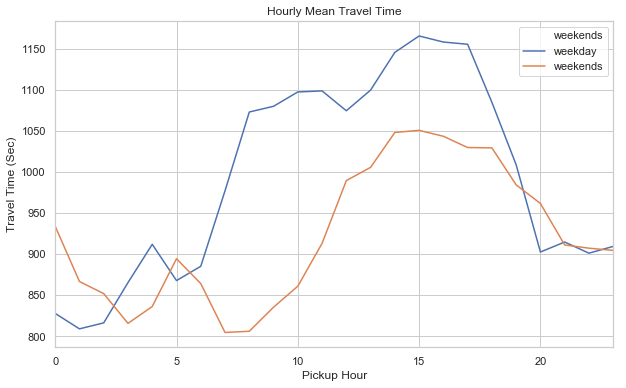

In [16]:
data['weekends'] = data.wkday.apply(lambda x: 'weekends' if (x=='Saturday') or (x=='Sunday') else 'weekday')

plt.figure(figsize=(10,6))

temp = pd.DataFrame(data.groupby(['pick_hour', 'weekends']).agg('mean')['travel_time']).reset_index()

ax = sns.lineplot(x='pick_hour', y='travel_time', hue='weekends', data=temp)
ax.set(xlabel='Pickup Hour', ylabel='Travel Time (Sec)', title='Hourly Mean Travel Time', xlim = (0,23))
plt.show()

### 2.2 Trave Time in Weekday

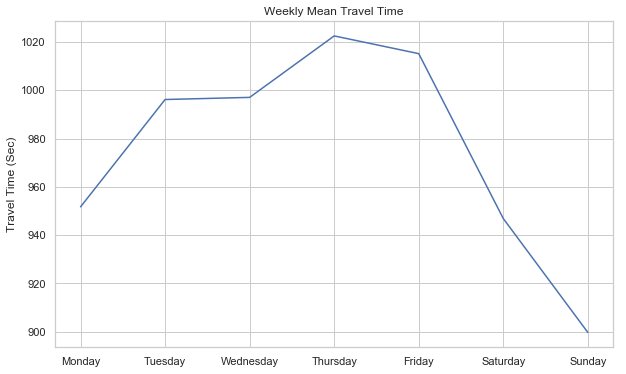

In [17]:
plt.figure(figsize=(10,6))

temp = pd.DataFrame(data.groupby(['wkday']).agg('mean')['travel_time']).reset_index()

ax = sns.lineplot(x='wkday', y='travel_time', data=temp)
ax.set(xlabel='', ylabel='Travel Time (Sec)', title='Weekly Mean Travel Time')
plt.show()

### 2.3 Travel Time in Weekday and Pickup Hour

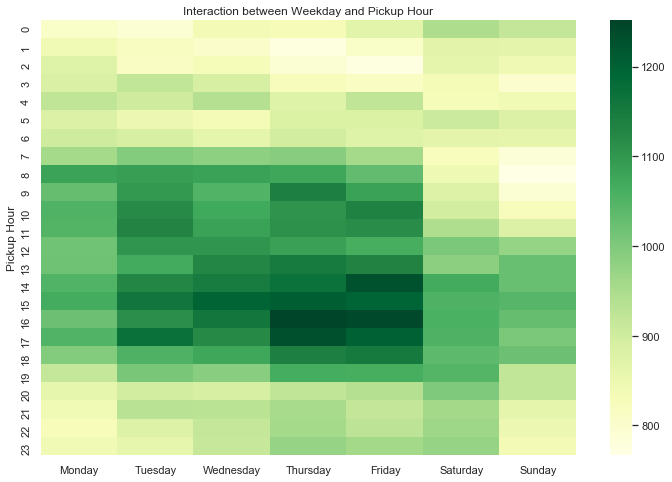

In [18]:
plt.figure(figsize=(12,8))

temp = pd.DataFrame(data.groupby(['wkday', 'pick_hour']).agg('mean')['travel_time']).reset_index()
temp = temp.pivot(index = 'pick_hour', columns = 'wkday', values = 'travel_time')

ax = sns.heatmap(temp, cmap="YlGn")
ax.set(xlabel='', ylabel='Pickup Hour', title = 'Interaction between Weekday and Pickup Hour')
plt.show()

### 2.4 Travel Time in Month

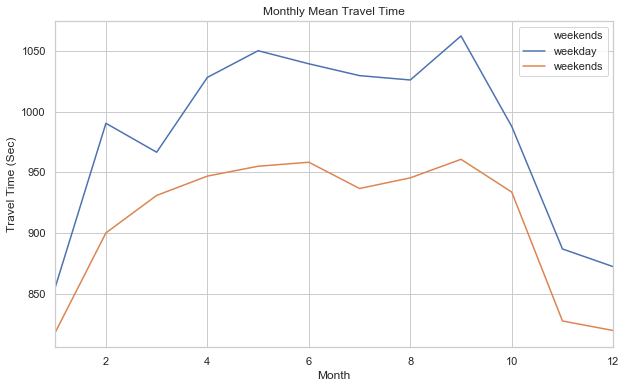

In [29]:
plt.figure(figsize=(10,6))

temp = pd.DataFrame(data.groupby(['month', 'weekends']).agg('mean')['travel_time']).reset_index()

ax = sns.lineplot(x='month', y='travel_time', hue='weekends', data=temp)
ax.set(xlabel='Month', ylabel='Travel Time (Sec)', title='Monthly Mean Travel Time', xlim = (1,12))
plt.show()

### 2.5 Travel Time in Month and Pickup Hour

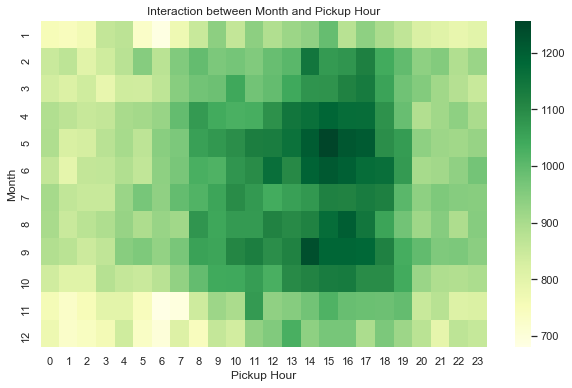

In [30]:
plt.figure(figsize=(10,6))

temp = pd.DataFrame(data.groupby(['month', 'pick_hour']).agg('mean')['travel_time']).reset_index()
temp = temp.pivot(index = 'month', columns = 'pick_hour', values = 'travel_time')

ax = sns.heatmap(temp, cmap="YlGn")
ax.set(xlabel='Pickup Hour', ylabel='Month', title = 'Interaction between Month and Pickup Hour')
plt.show()

### 2.6 Summary of Weather Data

In [21]:
data.columns

Index(['travel_time', 'pickup_datetime', 'dropoff_datetime', 'date', 'month',
       'day', 'wkday', 'pick_hour', 'pickup_location_id',
       'dropoff_location_id', 'type', 'AWND', 'PRCP', 'SNOW', 'SNWD', 'TMAX',
       'TMIN', 'pickup_borough', 'pickup_zone', 'pickup_longitude',
       'pickup_latitude', 'dropoff_borough', 'dropoff_zone',
       'dropoff_longitude', 'dropoff_latitude', 'weekends'],
      dtype='object')

In [ ]:
df_weather.hist(figsize=(8,15))

In [ ]:
corr = df_weather.corr()
cmap = sns.diverging_palette(250, 10, sep=20, as_cmap=True)
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap=cmap)

### Weather vs Trip Duration

In [ ]:
df = data[['date_of_year','travel_time', 'temp','visib','mxpsd', 'wdsp', 'gust', 'max', 'min', 'prcp', 'sndp', 
             'fog', 'rain_drizzle', 'snow_ice_pellets', 'hail', 'thunder']]
corr = df.corr()
cmap = sns.diverging_palette(250, 10, sep=20, as_cmap=True)
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap=cmap)

## 3. Feature Engineer

### 3.1 Transformation of Trip Duration

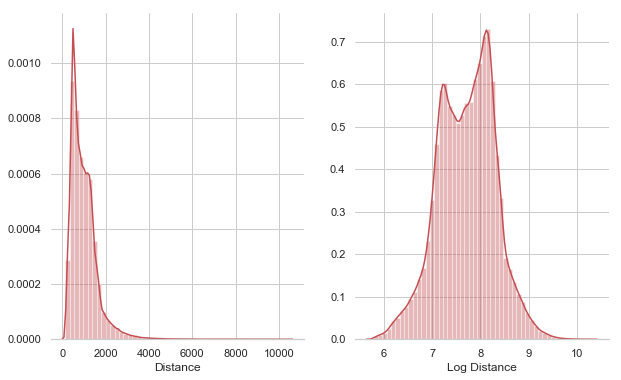

In [27]:
ff, axes = plt.subplots(ncols=2, figsize=(10, 6))
sns.despine(left=True)

sns.distplot(data['travel_time'].values+1, axlabel = 'Distance', label = 'Histogrqm of Distance', bins = 50, color='r', ax = axes[0])
# plt.setp(axes, yticks=[])
# plt.tight_layout()

sns.distplot(np.log(data['travel_time']).values+1, axlabel = 'Log Distance', label = 'Histogrqm of Distance', bins = 50, color='r', ax = axes[1])

### 3.2 Distance

In [52]:
# great circle distance
def haversine_(lat1, lng1, lat2, lng2):
    """calculate haversine distance between two co-ordinates"""
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return(h)

# manhattan distance
def manhattan_distance_pd(lat1, lng1, lat2, lng2):
    """calculate manhatten distance between pick_drop"""
    a = haversine_(lat1, lng1, lat1, lng2)
    b = haversine_(lat1, lng1, lat2, lng1)
    return a + b

In [53]:
data['haversine_distance'] = round(haversine_(data.pickup_latitude,data.pickup_longitude,data.dropoff_latitude,data.dropoff_longitude),3)
data['manhattan_distance'] = round(manhattan_distance_pd(data.pickup_latitude,data.pickup_longitude,data.dropoff_latitude,data.dropoff_longitude),3)

In [ ]:
def get_boundaries(sf):
    lat, lon = [], []
    for shape in list(sf.iterShapes()):
        lat.extend([shape.bbox[0], shape.bbox[2]])
        lon.extend([shape.bbox[1], shape.bbox[3]])

    margin = 0.01 # buffer to add to the range
    lat_min = min(lat) - margin
    lat_max = max(lat) + margin
    lon_min = min(lon) - margin
    lon_max = max(lon) + margin

    return lat_min, lat_max, lon_min, lon_max

In [51]:
sf = shapefile.Reader("shape/taxi_zones.shp")
fields_name = [field[0] for field in sf.fields[1:]]
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
attributes = sf.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]


get_boundaries(sf)

(-74.2655913631521, -73.69000906393539, 40.486115395170366, 40.92553277700258)

In [61]:
df_loc

,borough,location_i,objectid,shape_area,shape_leng,zone,longitude,latitude
0,EWR,1.0,1.0,0.000782,0.116357,Newark Airport,-74.171533,40.689483
1,Queens,2.0,2.0,0.004866,0.433470,Jamaica Bay,-73.822478,40.610824
2,Bronx,3.0,3.0,0.000314,0.084341,Allerton/Pelham Gardens,-73.844953,40.865747
3,Manhattan,4.0,4.0,0.000112,0.043567,Alphabet City,-73.977725,40.724137
4,Staten Island,5.0,5.0,0.000498,0.092146,Arden Heights,-74.187558,40.550664
5,Staten Island,6.0,6.0,0.000606,0.150491,Arrochar/Fort Wadsworth,-74.072566,40.599043
6,Queens,7.0,7.0,0.000390,0.107417,Astoria,-73.920307,40.761083
7,Queens,8.0,8.0,0.000027,0.027591,Astoria Park,-73.923122,40.778625
8,Queens,9.0,9.0,0.000338,0.099784,Auburndale,-73.786517,40.754343
9,Manhattan,24.0,24.0,0.000061,0.047000,Bloomingdale,-73.965522,40.801916


### 3.2 Holiday

In [31]:
us_holidays = holidays.UnitedStates()
data['holiday'] = data['date'].apply(lambda x: 1 if x in us_holidays else 0)

### 3.3 Rush Hour

In [34]:
# create dummy for rush hour
data['rush_hour'] = data.pick_hour.apply(lambda x: 1 if (x>=8) & (x<=17) else 0)

### 3.4 Bearing

In [35]:
data.columns

Index(['travel_time', 'pickup_datetime', 'dropoff_datetime', 'date', 'month',
       'day', 'wkday', 'pick_hour', 'pickup_location_id',
       'dropoff_location_id', 'type', 'AWND', 'PRCP', 'SNOW', 'SNWD', 'TMAX',
       'TMIN', 'pickup_borough', 'pickup_zone', 'pickup_longitude',
       'pickup_latitude', 'dropoff_borough', 'dropoff_zone',
       'dropoff_longitude', 'dropoff_latitude', 'weekends', 'holiday',
       'rush_hour'],
      dtype='object')

In [ ]:
def bearing_array(lat1, lng1, lat2, lng2):
    """calculate bearing for each trip"""
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

data['bearing'] = round(bearing_array(data.pickup_latitude,data.pickup_longitude,data.dropoff_latitude,data.dropoff_longitude),3)

### 3.6 Airport Trip

In [ ]:
data['airport'] = 0
xlim = [-73.80, -73.77]
ylim = [40.63, 40.65]
data.loc[(data.pickup_longitude> xlim[0]) & (data.pickup_longitude < xlim[1]) &
         (data.pickup_latitude> ylim[0]) & (data.pickup_latitude < ylim[1]), 'airport'] = 1
data.loc[(data.dropoff_longitude> xlim[0]) & (data.dropoff_longitude < xlim[1]) &
         (data.dropoff_latitude> ylim[0]) & (data.dropoff_latitude < ylim[1]), 'airport'] = 1

xlim = [-73.88, -73.85]
ylim = [40.76, 40.78]
data.loc[(data.pickup_longitude> xlim[0]) & (data.pickup_longitude < xlim[1]) &
     (data.pickup_latitude> ylim[0]) & (data.pickup_latitude < ylim[1]), 'airport'] = 1
data.loc[(data.dropoff_longitude> xlim[0]) & (data.dropoff_longitude < xlim[1]) &
     (data.dropoff_latitude> ylim[0]) & (data.dropoff_latitude < ylim[1]), 'airport'] = 1

## K-means Cluster
#### Cluster pickup and dropoff locations¶

In [ ]:
start = time.time()
loc_df = pd.DataFrame()
loc_df['longitude'] = data.pickup_longitude
loc_df['latitude'] = data.pickup_latitude
loc_df["dropoff_lat"] = data.dropoff_latitude
loc_df['dropoff_long'] = data.dropoff_longitude

kmeans = KMeans(n_clusters=25, random_state=2, n_init = 10).fit(loc_df)
loc_df['label'] = kmeans.labels_
plt.figure(figsize = (10,10))
for label in loc_df.label.unique():
    plt.plot(loc_df.longitude[loc_df.label == label],loc_df.latitude[loc_df.label == label],'.', alpha = 0.3, markersize = 10)

end = time.time()
print("Time taken by above cell is {}.".format(round((end-start)/60,2)))
    
plt.title('Clusters of New York')
plt.show()

data['cluster'] = loc_df.label

### Geohash

#### Add geohash to represent location

In [ ]:
start = time.time()
pickup = []
dropoff = []
for i in range(len(data)):
    
    dropoff.append(ghh.encode(data.dropoff_longitude.iloc[i], data.dropoff_latitude.iloc[i], precision=5))


data['dropoff_geo'] = dropoff
data["dropoff_geo_recode"] = data["dropoff_geo"].astype('category').cat.codes

end = time.time()
print("Time taken by above cell is {}.".format(round((end-start)/60,2)))

#### Plot geohash map

In [ ]:
from IPython.display import Image
Image(filename='geohash_pickup.png', width=500, height=300)

### Taxi Zone

## 4. Optimize the memory usage

In [ ]:
data = data.drop(['wdsp', 'gust', 'snow_ice_pellets', 'hail', 'thunder','dropoff_geo'], axis = 1)

In [ ]:
# Create a function to be calculating memory usage
def get_usage(obj):
    if isinstance(obj, pd.DataFrame):
        usage = obj.memory_usage(deep=True).sum()
    else:
        usage = obj.memory_usage(deep=True)
    return "{:03.2f} MB".format(usage / (1024**2))

# Convert object to int
obj = data.select_dtypes(include = 'object')
obj = obj.iloc[:,0:7]
obj_f32 = obj.apply(pd.to_numeric, downcast='unsigned')

# Convert int64 to int8
obj = data.select_dtypes(include = 'int64')
obj_int = obj.apply(pd.to_numeric, downcast='unsigned')

# Convert float64 to float32
obj = data.select_dtypes(include = 'float64')
obj_f = obj.apply(pd.to_numeric, downcast='float')

# Calculated the memory we reduced by down grade int and float
print("Original memory usage: ", get_usage(data))
data[obj_f32.columns] = obj_f32
data[obj_int.columns] = obj_int
data[obj_f.columns] = obj_f
print("After converting int and float memory usage: ", get_usage(data))

In [ ]:
data.head()

## Modeling

In [ ]:
selected_features = ['month', 'pickup_hour', 'weekday', 'holiday','rush_hour',
                     'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
                     'temp', 'visib', 'mxpsd',  'prcp', 'sndp', 'fog', 'passenger_count',
                     'bearing', 'airport','manhattan_distance','haversine_distance', 'dropoff_geo_recode'
                    ]

x = data[selected_features]
y = data['travel_time']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)

In [ ]:
def train_test_model_performance(clf, x_train = x_train, y_train = y_train, x_test = x_test, y_test = y_test):
    
    # Fit a model by providing X and y from training set
    clf.fit(x_train, y_train)
    print(clf)
    # Make prediction on the training data
    y_train_pred = clf.predict(x_train)

    # Make predictions on test data
    y_test_pred = clf.predict(x_test)
    
    # Evaluate
    R2_Train = clf.score(x_train,y_train)
    R2_Test = clf.score(x_test,y_test)
    RMSE_Train = sqrt(mean_squared_error(y_train, y_train_pred))
    RMSE_Test = sqrt(mean_squared_error(y_test, y_test_pred))
#     RMSLE_Train = sqrt(mean_squared_log_error(y_train, y_train_pred))
#     RMSLE_Test = sqrt(mean_squared_log_error(y_test, y_test_pred))
    
    metric_names = ['R2','RMSE']
    metric_values_train = [R2_Train, RMSE_Train]
    metric_values_test = [R2_Test, RMSE_Test]
    all_metrics = pd.DataFrame({'metrics':metric_names,
                                'train':metric_values_train,
                                'test':metric_values_test},columns=['metrics','train','test']).set_index('metrics')
    print(all_metrics)

In [ ]:
def cv_model_performance(clf, x_train = x_train, y_train = y_train, x_test = x_test, y_test = y_test):
    
    # Fit a model by providing X and y from training set
    clf.fit(x_train, y_train)
    model = clf.best_estimator_
    print(model)
    
    # Make prediction on the training data
    y_train_pred = model.predict(x_train)

    # Make predictions on test data
    y_test_pred = model.predict(x_test)
    
    # Evaluate
    R2_Train = model.score(x_train,y_train)
    R2_Test = model.score(x_test,y_test)
    RMSE_Train = sqrt(mean_squared_error(y_train, y_train_pred))
    RMSE_Test = sqrt(mean_squared_error(y_test, y_test_pred))
    RMSLE_Train = sqrt(mean_squared_log_error(y_train, y_train_pred))
    RMSLE_Test = sqrt(mean_squared_log_error(y_test, y_test_pred))
    
    metric_names = ['R2','RMSE','RMSLE']
    metric_values_train = [R2_Train, RMSE_Train, RMSLE_Train]
    metric_values_test = [R2_Test, RMSE_Test, RMSLE_Test]
    all_metrics = pd.DataFrame({'metrics':metric_names,
                                'train':metric_values_train,
                                'test':metric_values_test},columns=['metrics','train','test']).set_index('metrics')
    print(all_metrics)

### Random Forest

#### Cross Validation

In [ ]:
start = time.time()

# Choose the type of classifier. /
rf = RandomForestRegressor()

# Choose some parameter combinations to try
param_grid = {'n_estimators': [300,400], 
              'max_features': ['auto'], 
              'max_depth': [40,50], 
              'min_samples_split': [30, 50],
              'n_jobs':[-1]
             }

# read theory
grid_obj = GridSearchCV(rf, param_grid, cv=3, n_jobs = 8, iid=False, verbose=10, scoring='r2')
cv_model_performance(grid_obj)

end = time.time()
print("Time taken by above cell is {}.".format((end-start)/60))

#### Train RF

#### Feature Importance

In [ ]:
start = time.time()
# parameters = {'n_estimators': 300,
#              'max_features': 'auto',
#               'max_depth': 50,
#               'min_samples_split': 40,
#               'random_state': 2,
#               'n_jobs': -1,
#               }
# 0.899009  0.839094 25

parameters = {'n_estimators': 300,
             'max_features': 'auto',
              'max_depth': 50,
              'min_samples_split': 150,
              'random_state': 2,
              'n_jobs': -1
              }

rf = RandomForestRegressor(**parameters)
train_test_model_performance(rf)

end = time.time()
print("Time taken by above cell is {}.".format(round(end-start)/60,2))

In [ ]:
features = pd.DataFrame(list(zip(selected_features, rf.feature_importances_))).sort_values(by=[1], ascending=False)
features.columns = ['feature', 'value']

ax = features.iloc[0:10].plot.barh()
t = np.arange(11)
ax.set_yticks(t)
ax.set_yticklabels(features['feature'])
plt.show()

### Gradient Boosting Trees

#### Cross Validation

In [ ]:
start = time.time()
GBDT = GradientBoostingRegressor()

# Choose some parameter combinations to try
param_grid = {'n_estimators': [250, 300], 
              'max_depth': [10, 11], 
              'learning_rate': [0.2],
              'min_samples_split': [50, 55],
              'subsample':[0.9],
              'random_state': [2]
             }

# read theory
grid_obj = GridSearchCV(GBDT, param_grid, cv=3, n_jobs=8, iid=False, verbose=10, scoring='r2')
cv_model_performance(grid_obj)

end = time.time()
print("Time taken by above cell is {}.".format((end-start)/60))

#### Train GBDT

In [ ]:
start = time.time()

#Choose some parameter combinations to try
# parameters = {
#     'n_estimators': 150,
#     'max_depth': 7,
#     'learning_rate': 0.2,
#     'min_samples_split': 30,
#     'max_features': 'auto',
#     'subsample': 0.7,
#     'random_state': 2
# }

#0.797
parameters = {
    'n_estimators': 300,
    'max_depth': 9,
    'learning_rate': 0.2,
    'min_samples_split': 50,
    'subsample': 0.9,
    'random_state': 2
}

GBDT = GradientBoostingRegressor(**parameters)
train_test_model_performance(GBDT)

end = time.time()
print("Time taken by above cell is {}.".format(round((end-start)/60),2))

#### Feature Improtance

In [ ]:
features = pd.DataFrame(list(zip(selected_features, GBDT.feature_importances_))).sort_values(by=[1], ascending=False)
features.columns = ['feature', 'value']
features.head(10)

ax = features.iloc[0:10].plot.barh()
t = np.arange(11)
ax.set_yticks(t)
ax.set_yticklabels(features['feature'])
plt.show()

### Extremely Gradient Boosting (XGB)

#### Spliting Train and Test Data

In [ ]:
selected_features = ['month_of_year', 'day_of_year', 'pickup_hour', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
      'dropoff_latitude', 'passenger_count',  'prcp', 'sndp', 'fog', 'weekday', 'holiday', 
                     'haversine_distance','cluster','bearing','manhattan_distance']
x = data[selected_features]
y = np.log(data['travel_time'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)


In [ ]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dvalid = xgb.DMatrix(x_test, label=y_test)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

#### Grid Search CV for parameter selection

In [ ]:
from sklearn.grid_search import GridSearchCV 

parameters_for_testing = {
   'min_child_weight':[10,15],
   'max_depth':[15,17],
   'alpha':[10,15]
    
}
          
xgb_model = xgb.XGBRegressor(learning_rate =0.1, n_estimators=200, max_depth=12,
    min_child_weight=10, subsample=0.6, colsample_bytree=0.6, nthread= 8, scale_pos_weight=1, seed=27)

gsearch1 = GridSearchCV(estimator = xgb_model, param_grid = parameters_for_testing, cv=3, n_jobs=8,iid=False, verbose=10,scoring='r2')
gsearch1.fit(x_train,y_train)
print (gsearch1.grid_scores_)
print('best params')
print (gsearch1.best_params_)
print('best score')
print (gsearch1.best_score_)

#### Train model 

In [ ]:
start = time.time()
xgb_pars = {'min_child_weight': 15, 'eta': 0.1, 'colsample_bytree': 0.7, 
            'max_depth': 15, 'alpha' : 15,
            'subsample': 0.7,'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear','lambda':1}
model = xgb.train(xgb_pars, dtrain, 250, watchlist, early_stopping_rounds=2,
      maximize=False, verbose_eval=1)
print('Modeling RMSE %.5f' % model.best_score)

end = time.time()
print("Time taken by above cell is {}.".format(round((end-start)/60),2))

#### Feature Improtance

In [ ]:
xgb.plot_importance(model, max_num_features=28, height=0.5)

#### Evaluate model performance

In [ ]:
# Make prediction on the training data
y_train_pred = model.predict(dtrain)

# Make predictions on test data
y_test_pred = model.predict(dvalid)

# Evaluate
R2_Train = r2_score(y_train_pred, y_train)
R2_Test = r2_score(y_test_pred, y_test)
RMSE_Train = sqrt(mean_squared_error(y_train, y_train_pred))
RMSE_Test = sqrt(mean_squared_error(y_test, y_test_pred))

metric_names = ['R2','RMSE']
metric_values_train = [R2_Train, RMSE_Train]
metric_values_test = [R2_Test, RMSE_Test]
all_metrics = pd.DataFrame({'metrics':metric_names,
                            'train':metric_values_train,
                            'test':metric_values_test},columns=['metrics','train','test']).set_index('metrics')
print(all_metrics)


In [ ]:
# Make prediction on the training data
y_train_pred = model.predict(dtrain)

# Make predictions on test data
y_test_pred = model.predict(dvalid)

# Evaluate
R2_Train = r2_score(y_train_pred, y_train)
R2_Test = r2_score(y_test_pred, y_test)
RMSE_Train = sqrt(mean_squared_error(y_train, y_train_pred))
RMSE_Test = sqrt(mean_squared_error(y_test, y_test_pred))

metric_names = ['R2','RMSE']
metric_values_train = [R2_Train, RMSE_Train]
metric_values_test = [R2_Test, RMSE_Test]
all_metrics = pd.DataFrame({'metrics':metric_names,
                            'train':metric_values_train,
                            'test':metric_values_test},columns=['metrics','train','test']).set_index('metrics')
print(all_metrics)

In [ ]:
data.shape

## Prediction

In [ ]:
def haversine_(lat1, lng1, lat2, lng2):
    """function to calculate haversine distance between two co-ordinates"""
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = round(2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d)),3)
    return(h)

def manhattan_distance_pd(lat1, lng1, lat2, lng2):
    """function to calculate manhatten distance between pick_drop"""
    a = haversine_(lat1, lng1, lat1, lng2)
    b = haversine_(lat1, lng1, lat2, lng1)
    return a + b

def feature_engineer(data):
    start = time.time()
    
    # create distance_in_km
    data['haversine_distance'] = haversine_(data.pickup_latitude,data.pickup_longitude,data.dropoff_latitude,data.dropoff_longitude)

    # create mahattan dist
    data['manhattan_distance'] = manhattan_distance_pd(data.pickup_latitude,data.pickup_longitude,data.dropoff_latitude,data.dropoff_longitude)

    # create bearing
    data['bearing'] = bearing_array(data.pickup_latitude,data.pickup_longitude,data.dropoff_latitude,data.dropoff_longitude)

    # create weekday
    data["weekday"] = data['pickup_datetime'].dt.dayofweek

    # create holiday
    us_holidays = holidays.UnitedStates()
    data['holiday'] = data['date_of_year'].apply(lambda x: 1 if x in us_holidays else 0)
    
    # K-means clustering
    location = data.loc[:, ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']]
    kmeans = KMeans(n_clusters=50, random_state=123, n_init = 10, n_jobs = 4).fit(location)
    data['cluster'] = kmeans.labels_
  
    # create geo hash (clustering the pickup and dropoff spots)
#     pickup = []
    dropoff = []
    for i in range(len(data)):
        dropoff.append(ghh.encode(data.dropoff_longitude.iloc[i], data.dropoff_latitude.iloc[i], precision=5))

    data['dropoff_geo_recode'] = dropoff
    data["dropoff_geo_recode"] = data["dropoff_geo_recode"].astype('category').cat.codes

    
    end = time.time()
    print("Time taken by above function is {}.".format((end-start)/60))
    
    return(data)

In [ ]:
# Create a function to be calculating memory usage
def get_usage(obj):
    if isinstance(obj, pd.DataFrame):
        usage = obj.memory_usage(deep=True).sum()
    else:
        usage = obj.memory_usage(deep=True)
    return "{:03.2f} MB".format(usage / (1024**2))

def optimizing(data):
    start = time.time()
        
    # Convert object to int
    obj = data.select_dtypes(include = 'object')
    obj_f32 = obj.apply(pd.to_numeric, downcast='unsigned')

    # Convert int64 to int8
    obj = data.select_dtypes(include = 'int64')
    obj_int = obj.apply(pd.to_numeric, downcast='unsigned')

    # Convert float64 to float32
    obj = data.select_dtypes(include = 'float64')
    obj_f = obj.apply(pd.to_numeric, downcast='float')

    # Calculated the memory we reduced by down grade int and float
    print("Original memory usage: ", get_usage(data))
    data[obj_f32.columns] = obj_f32
    data[obj_int.columns] = obj_int
    data[obj_f.columns] = obj_f
    print("After converting int and float memory usage: ", get_usage(data))
    
    end = time.time()
    print("Time taken by above function is {}.".format((end-start)/60))
    
    return(data)

In [ ]:
def pre_processing(data, weather):
    data = data.reset_index()
    weather = weather[['day', 'month', 'prcp', 'sndp', 'fog', 'visib', 'mxpsd', 'wdsp','gust']]
    data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
    data['date_of_year'] = pd.to_datetime(data['pickup_datetime'].dt.date)
    data['month_of_year'] = data['pickup_datetime'].dt.month
    data['pickup_hour'] = data['pickup_datetime'].dt.hour
    data['day_of_year'] = data['pickup_datetime'].dt.day
    data = pd.merge(data, weather, how = 'inner', left_on = ['day_of_year','month_of_year'], right_on = ['day','month'])
    data = data.sort_values(by=['index']).reset_index()
    return(data)

#### Loading Testing Data

In [ ]:
taxi = pd.read_csv("./APM4990_final_test_data_filtered.csv")
weather_2015 = pd.read_csv("./weather_2015_cleaned.csv")

#### Pre-processing

In [ ]:
test = pre_processing(taxi, weather_2015)

#### Feature Engineer

In [ ]:
test = feature_engineer(test)

#### Data Optimiziing

In [ ]:
test = optimizing(test)

In [ ]:
selected_features = ['month_of_year', 'day_of_year', 'pickup_hour', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'cluster',
       'dropoff_latitude', 'passenger_count', 'bearing',  'prcp', 'sndp', 'fog', 'weekday', 'holiday', 'manhattan_distance','haversine_distance','dropoff_geo_recode']

test = test[selected_features]

In [ ]:
y_pred_GBDT = np.exp(GBDT.predict(test))

In [ ]:
result = pd.DataFrame({'predictions':y_pred_GBDT})

In [ ]:
result.to_csv('./result.csv',index = False)